<a href="https://colab.research.google.com/github/YuliiaHudz/Data-Analytics-Projects/blob/main/Project_2_Multi_Tool_E_Commerce_Analysis_SQL_Python_and_Tableau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Stage 1: Data Processing and Analytical Exploration (SQL and Python)**


In [2]:
from google.colab import auth
from google.cloud import bigquery
from statsmodels.stats.proportion import proportions_ztest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency, fisher_exact

from IPython.display import display
import plotly.express as px

!pip install squarify # Install the Squarify library for creating treemaps
import squarify

auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")

query = """
-- Step 1: Extract session-related details, including user info, device, location, and traffic source
WITH session_info AS (
    SELECT
        s.date AS order_date,
        s.ga_session_id,
        sp.continent,
        sp.country,
        sp.device,
        sp.browser,
        sp.mobile_model_name AS device_model,
        sp.operating_system,
        sp.language AS browser_language,
        sp.medium AS traffic_source,
        sp.channel AS traffic_channel,
        ac.id AS registered_user_id,
        ac.is_verified AS email_confirmed,
        ac.is_unsubscribed AS subscribed_to_newsletter
    FROM `DA.session` s
    JOIN `DA.session_params` sp
        ON sp.ga_session_id = s.ga_session_id
    LEFT JOIN `DA.account_session` acs
        ON acs.ga_session_id = s.ga_session_id
    LEFT JOIN `DA.account` ac
        ON ac.id = acs.account_id
),

-- Step 2: Extract order-related details, linking products to sessions
order_info AS (
    SELECT
        o.ga_session_id,
        p.category AS product_category,
        p.name AS product_name,
        p.price,
        p.short_description AS product_description
    FROM `DA.order` o
    JOIN `DA.product` p
        ON o.item_id = p.item_id
)

-- Step 3: Combine session and order details based on session ID
SELECT
    si.order_date,
    si.ga_session_id,
    si.continent,
    si.country,
    si.device,
    si.browser,
    si.device_model,
    si.operating_system,
    si.browser_language,
    si.traffic_source,
    si.traffic_channel,
    si.registered_user_id,
    si.email_confirmed,
    si.subscribed_to_newsletter,
    oi.product_category,
    oi.product_name,
    oi.price,
    oi.product_description
FROM session_info si
JOIN order_info oi
    ON si.ga_session_id = oi.ga_session_id;
"""
query_job = client.query(query)
results = query_job.result()

df = results.to_dataframe()
df.head()

,order_date,ga_session_id,continent,country,device,browser,device_model,operating_system,browser_language,traffic_source,traffic_channel,registered_user_id,email_confirmed,subscribed_to_newsletter,product_category,product_name,price,product_description
0,2020-12-24,5726438444,(not set),(not set),desktop,Chrome,Chrome,Web,None,referral,Paid Search,<NA>,<NA>,<NA>,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,(not set),(not set),desktop,<Other>,<Other>,Web,en-ca,organic,Organic Search,<NA>,<NA>,<NA>,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,(not set),(not set),desktop,Chrome,Safari,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"


**Explanation:** In this part, a BigQuery client is set up to interact with Google BigQuery, and a SQL query is defined to extract and combine session and order data. The query joins session-related information, such as user device, location, and traffic source, with order-related details like product categories, names, and prices. The data is aggregated by session ID and linked with product information to create a comprehensive view of user interactions. The query is executed in BigQuery, and the results are converted into a Pandas DataFrame for further analysis. Finally, the first few rows of the DataFrame are displayed for inspection.

# **General description of the dataset**

In [ ]:
# 1. Total number of columns
total_columns = df.shape[1]
print(f"Total number of columns: {total_columns}")

Total number of columns: 18


In [ ]:
# 2. Count of numeric columns and their names
numeric_columns = df.select_dtypes(include='number').columns.tolist()
print(f"Numeric columns: {numeric_columns}")

Numeric columns: ['ga_session_id', 'registered_user_id', 'email_confirmed', 'subscribed_to_newsletter', 'price']


In [ ]:
# 3. Count of categorical columns and their names
categorical_columns = df.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns: {categorical_columns}")

Categorical columns: ['continent', 'country', 'device', 'browser', 'device_model', 'operating_system', 'browser_language', 'traffic_source', 'traffic_channel', 'product_category', 'product_name', 'product_description']


In [ ]:
# 4. Count of datetime columns and their names
datetime_columns = df.select_dtypes(include='datetime').columns.tolist()
print(f"Datetime columns: {datetime_columns}")

Datetime columns: []


In [ ]:
# 4.1 Converting proper columns to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Now check again for datetime columns
datetime_columns = df.select_dtypes(include='datetime').columns.tolist()
print(f"Datetime columns after conversion: {datetime_columns}")

Datetime columns after conversion: ['order_date']


In [ ]:
# 5. Number of unique sessions (assuming 'ga_session_id' is the column for sessions)
unique_sessions = df['ga_session_id'].nunique()
print(f"Number of unique sessions: {unique_sessions}")

Number of unique sessions: 33538


In [ ]:
# 6. Time period (start and end dates)
date_range = (df['order_date'].min(), df['order_date'].max())
print(f"Date range: From {date_range[0]} to {date_range[1]}")

Date range: From 2020-11-01 00:00:00 to 2021-01-27 00:00:00


In [ ]:
# 7. Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

Missing values per column:
order_date                      0
ga_session_id                   0
continent                       0
country                         0
device                          0
browser                         0
device_model                    0
operating_system                0
browser_language            11007
traffic_source                  0
traffic_channel                 0
registered_user_id          30757
email_confirmed             30757
subscribed_to_newsletter    30757
product_category                0
product_name                    0
price                           0
product_description             0
dtype: int64


In [ ]:
# 8. Columns with more missing values
columns_with_missing_values = missing_values[missing_values > 0]
print(f"Columns with the most missing values:\n{columns_with_missing_values}")

Columns with the most missing values:
browser_language            11007
registered_user_id          30757
email_confirmed             30757
subscribed_to_newsletter    30757
dtype: int64


In [ ]:
# 8.1 Fill missing values in the 'browser_language' column with 'Unknown'
df['browser_language'] = df['browser_language'].fillna('Unknown')

# Print the result to check the changes
print(df['browser_language'].head())

0    Unknown
1      en-ca
2      en-us
3      en-us
4      en-gb
Name: browser_language, dtype: object


In [ ]:
# 8.2 Fill missing values and 0 in the 'email_confirmed' column with False, and replace 1 with True

# Ensure the column is of boolean type before filling NaN
df['email_confirmed'] = df['email_confirmed'].astype('boolean')

# Fill NaN values with False (not confirmed)
df['email_confirmed'] = df['email_confirmed'].fillna(False)

# Check the distinct values after transformation
distinct_values = df['email_confirmed'].unique()

# Print the distinct values
print(distinct_values)

<BooleanArray>
[False, True]
Length: 2, dtype: boolean


In [ ]:
# 8.3 Fill missing values and 0 in the 'subscribed_to_newsletter' column with False, and replace 1 with True

# Ensure the column is of boolean type before filling NaN
df['subscribed_to_newsletter'] = df['subscribed_to_newsletter'].astype('boolean')

# Fill NaN values with False (not subscribed)
df['subscribed_to_newsletter'] = df['subscribed_to_newsletter'].fillna(False)

# Check the distinct values after transformation
distinct_values = df['subscribed_to_newsletter'].unique()

# Print the distinct values
print(distinct_values)

<BooleanArray>
[False, True]
Length: 2, dtype: boolean


In [ ]:
# 9. Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [ ]:
# 10. Basic Statistics for numeric columns
numeric_summary = df[numeric_columns].describe()
print(f"Basic statistics for numeric columns: \n{numeric_summary}")

Basic statistics for numeric columns: 
           ga_session_id  registered_user_id         price
count            33538.0              2781.0  33538.000000
mean   4964900683.146312       658815.525351    953.298679
std    2884281407.544152        13140.190977   1317.001775
min             330355.0            636138.0      3.000000
25%         2476893918.0            647432.0    170.000000
50%         4961245290.0            658322.0    445.000000
75%        7442296865.75            670218.0   1195.000000
max         9999754183.0            681955.0   9585.000000


In [ ]:
11. # Value counts for categorical columns
categorical_value_counts = {col: df[col].value_counts() for col in categorical_columns}
print(f"Value counts for categorical columns: {categorical_value_counts}")

Value counts for categorical columns: {'continent': continent
Americas     18553
Asia          7950
Europe        6261
Oceania        364
Africa         339
(not set)       71
Name: count, dtype: int64, 'country': country
United States           14673
India                    3029
Canada                   2560
United Kingdom           1029
France                    678
                        ...  
Bahrain                     5
Honduras                    5
Bosnia & Herzegovina        5
Bahamas                     4
Luxembourg                  3
Name: count, Length: 108, dtype: int64, 'device': device
desktop    19702
mobile     13113
tablet       723
Name: count, dtype: int64, 'browser': browser
Chrome             23015
Safari              7903
<Other>              865
Edge                 752
Firefox              583
Android Webview      420
Name: count, dtype: int64, 'device_model': device_model
Chrome        9359
Safari        6833
iPhone        6819
<Other>       6801
ChromeBook  

**Explanation:** Exploratory data analysis is conducted to understand the dataset's structure and contents. The process starts by examining the number and types of columns, converting the 'order_date' column to datetime format, and identifying unique sessions along with the overall date range. Missing values are then assessed and filled in specific columns, including 'browser_language', 'email_confirmed', and 'subscribed_to_newsletter'. Duplicate entries are checked, and basic statistical summaries are calculated for numerical columns. Value counts for categorical columns are also provided to analyze their distribution. This comprehensive approach ensures data quality and prepares the dataset for further analysis.

# **Analysis and Insights: Sales Performance by Region, Product Category, Traffic Source, and User Behavior**

## ***1. Top 3 Continents by Sales and Orders***

In [ ]:
sales_by_continent = df.groupby('continent').agg({'price': 'sum', 'ga_session_id': 'nunique'}).reset_index()
top_3_continents_by_sales = sales_by_continent.sort_values(by='price', ascending=False).head(3)

# Display the results as table
display(top_3_continents_by_sales)

,continent,price,ga_session_id
2,Americas,17665280.0,18553
3,Asia,7601298.3,7950
4,Europe,5934624.2,6261


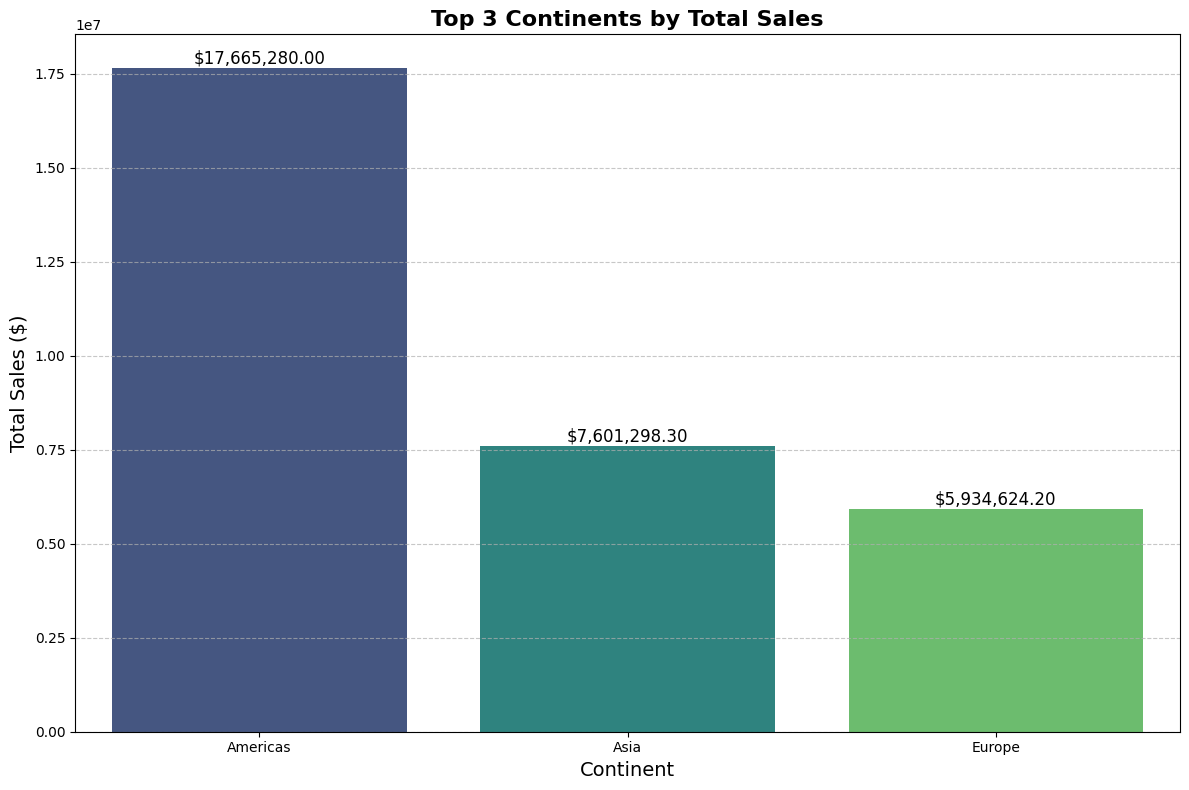

In [ ]:
# Visualizations

plt.figure(figsize=(12,8))

# Assigning 'continent' to 'hue' to avoid the warning
sns.barplot(x='continent', y='price', data=top_3_continents_by_sales, hue='continent', palette="viridis")

# Adding title and labels with a more stylish font
plt.title('Top 3 Continents by Total Sales', fontsize=16, fontweight='bold')
plt.xlabel('Continent', fontsize=14)
plt.ylabel('Total Sales ($)', fontsize=14)

# Adding a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels to show the actual sales on top of each bar
for index, value in enumerate(top_3_continents_by_sales['price']):
    plt.text(index, value + 2000, f'${value:,.2f}', ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## ***2. Top 5 Countries by Sales and Orders***

In [ ]:
top_5_countries_by_sales = df.groupby('country').agg({'price': 'sum', 'ga_session_id': 'nunique'}).reset_index().sort_values(by='price', ascending=False).head(5)

# Display the results as table
display(top_5_countries_by_sales)

,country,price,ga_session_id
104,United States,13943553.9,14673
43,India,2809762.0,3029
18,Canada,2437921.0,2560
103,United Kingdom,938317.9,1029
33,France,710692.8,678


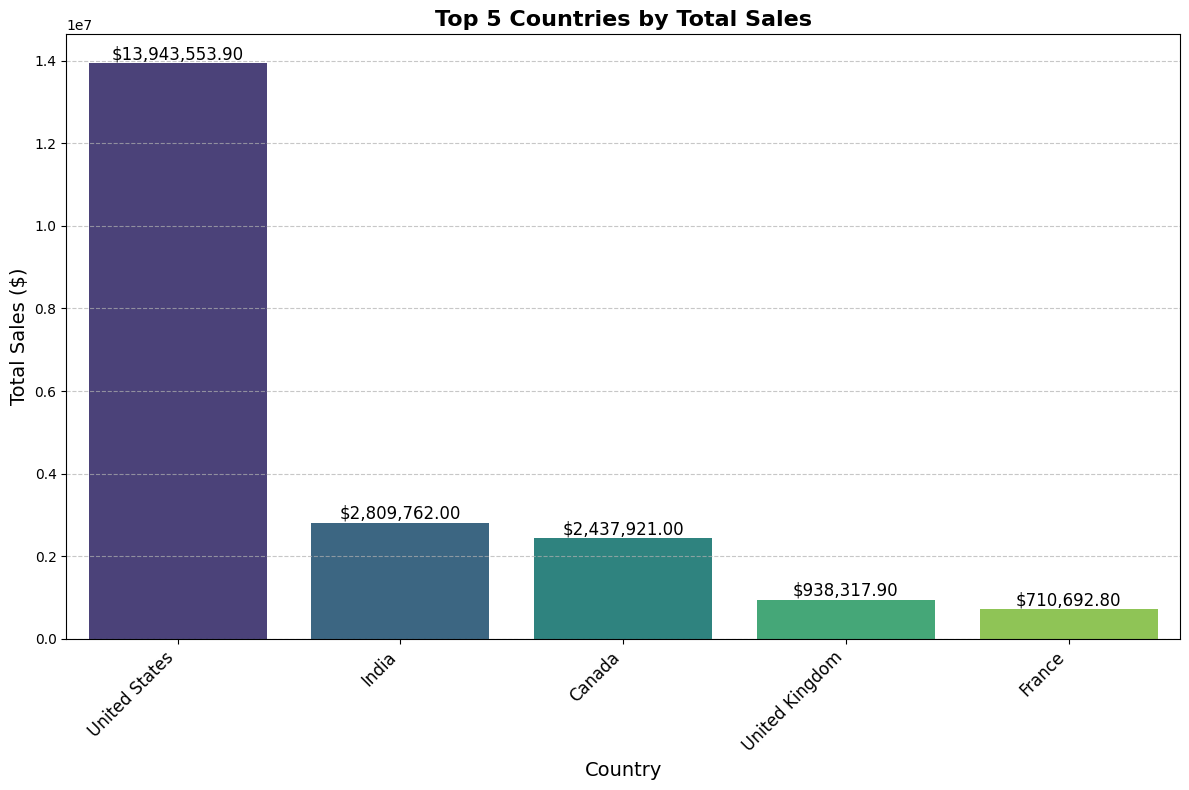

In [ ]:
# Visualization
plt.figure(figsize=(12, 8))

# Assign the 'country' to 'hue' to prevent the FutureWarning
sns.barplot(x='country', y='price', data=top_5_countries_by_sales, hue='country', palette='viridis', legend=False)

# Adding a title with customized font and weight
plt.title('Top 5 Countries by Total Sales', fontsize=16, fontweight='bold')

# Adding labels with bigger font size for better readability
plt.xlabel('Country', fontsize=14)
plt.ylabel('Total Sales ($)', fontsize=14)

# Rotate the x-axis labels for better clarity when there are long country names
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding a grid to help with readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotating each bar with the corresponding sales value
for index, value in enumerate(top_5_countries_by_sales['price']):
    plt.text(index, value + 1000, f'${value:,.2f}', ha='center', va='bottom', fontsize=12, color='black')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## ***3. Top 10 Product Categories by Total Sales***

In [ ]:
top_10_categories_by_sales = df.groupby('product_category').agg({'price': 'sum'}).reset_index().sort_values(by='price', ascending=False).head(10)

# Display the results as table
display(top_10_categories_by_sales)

,product_category,price
12,Sofas & armchairs,8388254.5
5,Chairs,6147748.8
1,Beds,4919725.0
2,Bookcases & shelving units,3640818.1
3,Cabinets & cupboards,2336499.5
9,Outdoor furniture,2142222.2
13,Tables & desks,1790307.5
6,Chests of drawers & drawer units,906562.5
0,Bar furniture,735503.0
7,Children's furniture,467697.0


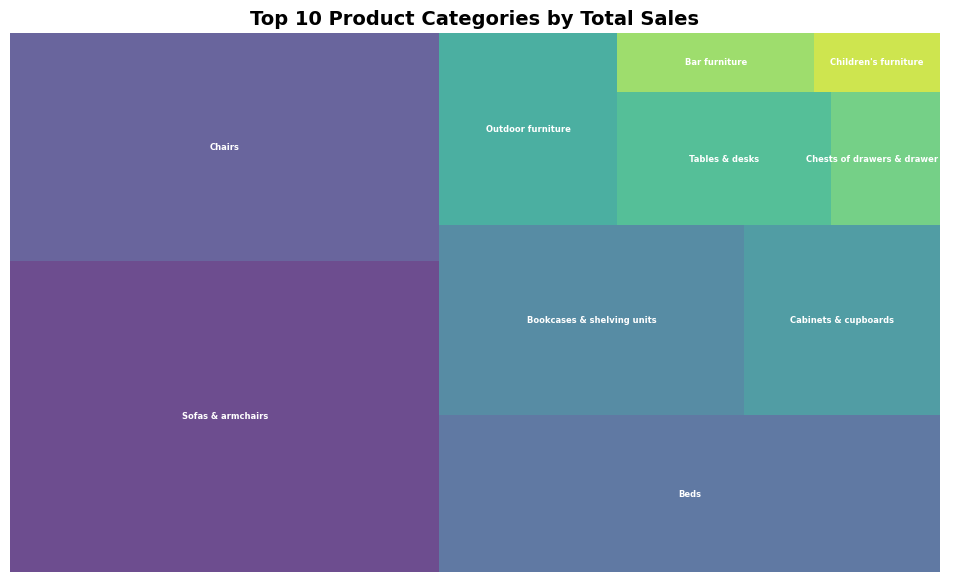

In [ ]:
# Visualization

# Define colors using the 'viridis' colormap
colors = sns.color_palette('viridis', len(top_10_categories_by_sales))

# Create the figure
plt.figure(figsize=(12, 7))

# Create the treemap
squarify.plot(
    sizes=top_10_categories_by_sales['price'],
    label=top_10_categories_by_sales['product_category'],
    alpha=0.8,
    color=colors,
    text_kwargs={'fontsize': 6, 'weight': 'bold', 'color': 'white'}
)

# Add title
plt.title('Top 10 Product Categories by Total Sales', fontsize=14, fontweight='bold')

# Remove axes for a cleaner look
plt.axis('off')

# Show the plot
plt.show()

## ***4. Top 10 Product Categories in the Country with Highest Sales (Comparison with Overall)***

In [ ]:
country_with_highest_sales = top_5_countries_by_sales.iloc[0]['country']
top_10_categories_in_top_country = df[df['country'] == country_with_highest_sales].groupby('product_category').agg({'price': 'sum'}).reset_index().sort_values(by='price', ascending=False).head(10)

# Display the results as table
display(top_10_categories_in_top_country)

,product_category,price
12,Sofas & armchairs,3707144.5
5,Chairs,2619773.8
1,Beds,2213058.0
2,Bookcases & shelving units,1567606.9
3,Cabinets & cupboards,994545.5
9,Outdoor furniture,929245.2
13,Tables & desks,777865.0
6,Chests of drawers & drawer units,382388.0
0,Bar furniture,330805.0
7,Children's furniture,207575.0


## ***5. Sales by Device Types (as percentage of total sales)***

In [ ]:
sales_by_device = df.groupby('device').agg({'price': 'sum'}).reset_index()
sales_by_device['percentage'] = (sales_by_device['price'] / sales_by_device['price'].sum()) * 100

# Display the results as tables
display(sales_by_device)

,device,price,percentage
0,desktop,18864039.0,59.002245
1,mobile,12384225.8,38.734924
2,tablet,723466.3,2.262831


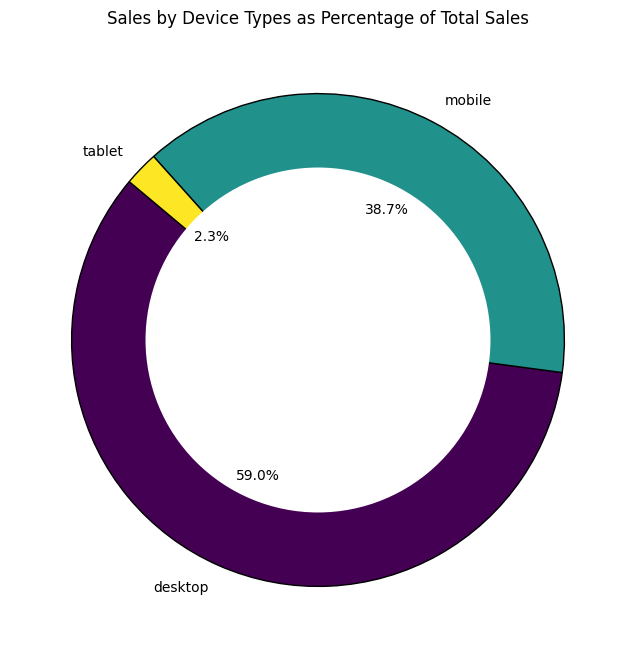

In [ ]:
# Visualization

# Define colors using the 'viridis' colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(sales_by_device)))

# Create a pie chart (Donut Chart)
plt.figure(figsize=(12, 8))
plt.pie(
    sales_by_device["percentage"],
    labels=sales_by_device["device"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)

# Add a white circle in the center to create the "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
plt.gca().add_artist(centre_circle)

plt.title("Sales by Device Types as Percentage of Total Sales")
plt.show()

## ***6. Sales by Device Models (as percentage of total sales)***

In [ ]:
sales_by_device_model = df.groupby('device_model').agg({'price': 'sum'}).reset_index()
sales_by_device_model['percentage'] = (sales_by_device_model['price'] / sales_by_device_model['price'].sum()) * 100

# Display the results as tables
display(sales_by_device_model)

,device_model,price,percentage
0,<Other>,6535330.8,20.440966
1,Chrome,8899523.9,27.835602
2,ChromeBook,1830458.7,5.725241
3,Edge,697222.3,2.180746
4,Firefox,421066.9,1.316998
5,Pixel 3,109148.2,0.341390
6,Pixel 4 XL,118287.7,0.369976
7,Safari,6491062.1,20.302504
8,iPad,448854.2,1.403910
9,iPhone,6420776.3,20.082667


## ***7. Sales by Traffic Source (as percentage of total sales)***

In [ ]:
sales_by_traffic_source = df.groupby('traffic_source').agg({'price': 'sum'}).reset_index()
sales_by_traffic_source['percentage'] = (sales_by_traffic_source['price'] / sales_by_traffic_source['price'].sum()) * 100

# Display the results as tables
display(sales_by_traffic_source)

,traffic_source,price,percentage
0,(data deleted),2041921.0,6.386645
1,(none),7494923.4,23.442345
2,<Other>,4491351.1,14.047882
3,cpc,1366440.5,4.273902
4,organic,10935239.9,34.202840
5,referral,5641855.2,17.646386


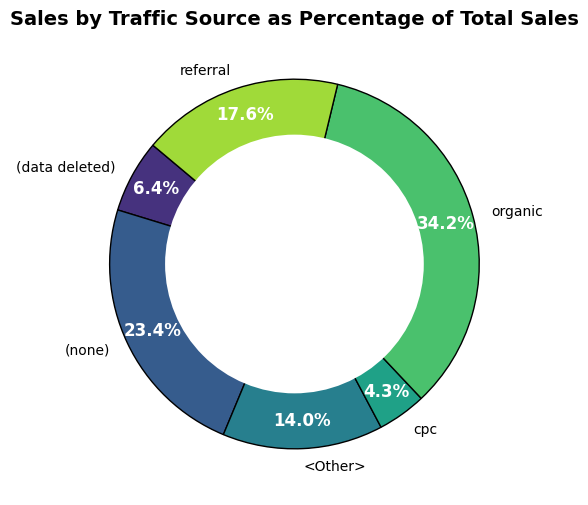

In [ ]:
# Visualization

# Define colors using the 'viridis' colormap
colors = sns.color_palette('viridis', len(sales_by_traffic_source))

# Create a donut chart
plt.figure(figsize=(12, 6))

# Pie chart with a hole in the middle (donut effect)
wedges, texts, autotexts = plt.pie(
    sales_by_traffic_source['percentage'],
    labels=sales_by_traffic_source['traffic_source'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    pctdistance=0.85,  # Position of percentage labels
)

# Draw a white circle in the center to make it a donut chart
center_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(center_circle)

# Add title
plt.title('Sales by Traffic Source as Percentage of Total Sales', fontsize=14, fontweight='bold')

# Improve text visibility
for text in autotexts:
    text.set_color('white')
    text.set_fontsize(12)
    text.set_fontweight('bold')

# Show the plot
plt.show()

## ***8. Percentage of Registered Users Who Confirmed Their Email***

In [ ]:
confirmed_email_percentage = (df[df['email_confirmed'] == True].shape[0] / df[df['registered_user_id'].notnull()].shape[0]) * 100

# Display the results as tables
display(confirmed_email_percentage)

71.52103559870551

## ***7. Percentage of Registered Users Who Unsubscribed***

In [ ]:
unsubscribed_percentage = (df[df['subscribed_to_newsletter'] == False].shape[0] / df[df['registered_user_id'].notnull()].shape[0]) * 100

# Display the results as tables
display(unsubscribed_percentage)

1189.8957209636822

## ***9. Sales Behavior Comparison: Unsubscribed vs Subscribed Users***

In [ ]:
sales_behavior_comparison = df.groupby('subscribed_to_newsletter').agg({'price': 'sum', 'ga_session_id': 'nunique'}).reset_index()

# Display the results as tables
display(sales_behavior_comparison)

,subscribed_to_newsletter,price,ga_session_id
0,False,31540009.5,33091
1,True,431721.6,447


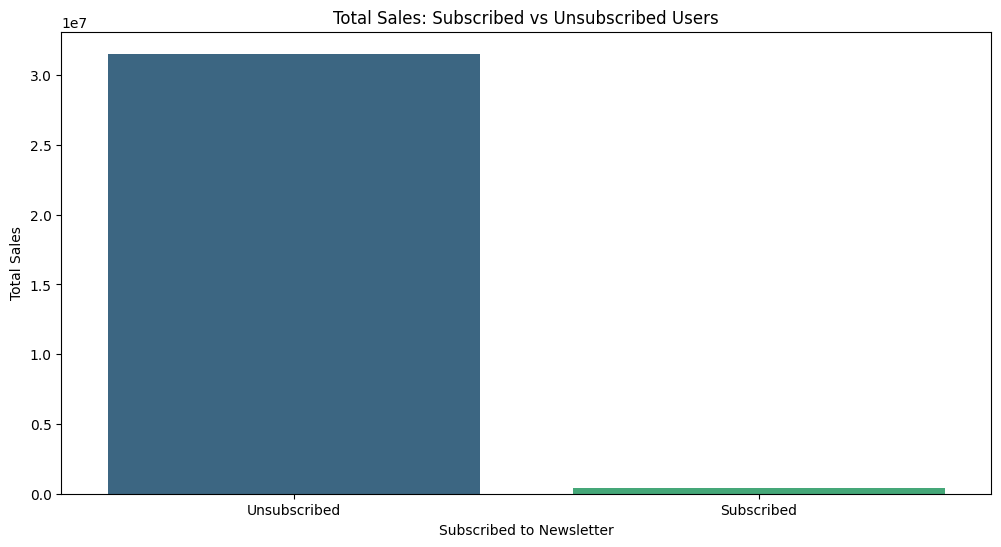

In [ ]:
# Visualization
plt.figure(figsize=(12,6))
sns.barplot(
    x="subscribed_to_newsletter",
    y="price",
    hue="subscribed_to_newsletter",  # Assigning x variable to hue
    data=sales_behavior_comparison,
    palette="viridis",
    estimator=sum,
    legend=False  # Hides redundant legend
)
plt.title("Total Sales: Subscribed vs Unsubscribed Users")
plt.ylabel("Total Sales")
plt.xlabel("Subscribed to Newsletter")
plt.xticks([0, 1], ["Unsubscribed", "Subscribed"])
plt.show()

## ***10. Countries with the Most Registered Users***

In [ ]:
countries_with_most_registered_users = df.groupby('country').agg({'registered_user_id': 'nunique'}).reset_index().sort_values(by='registered_user_id', ascending=False)

# Display the results as tables
display(countries_with_most_registered_users)

,country,registered_user_id
104,United States,1207
43,India,246
18,Canada,207
103,United Kingdom,88
33,France,56
...,...,...
83,Qatar,0
76,Panama,0
77,Paraguay,0
98,Trinidad & Tobago,0


## ***11. Additional Insight: Registered Users' Sales by Country***

In [ ]:
sales_by_registered_users_country = df[df['registered_user_id'].notnull()].groupby('country').agg({'price': 'sum'}).reset_index().sort_values(by='price', ascending=False)

# Display the results as tables
display(sales_by_registered_users_country)

,country,price
83,United States,1100367.8
32,India,207605.5
14,Canada,192894.4
68,Singapore,65691.8
82,United Kingdom,65141.5
...,...,...
84,Uruguay,100.0
58,Oman,54.7
12,Bulgaria,22.0
1,Albania,15.0


In [ ]:
# Visualization

# Create choropleth map
fig = px.choropleth(
    sales_by_registered_users_country,
    locations="country",
    locationmode="country names",
    color="price",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.Viridis,
    title="Sales by Registered Users by Country"
)

fig.update_layout(
    geo=dict(showcoastlines=True, projection_type="natural earth"),
    title_x=0.5
)

fig.show()

**Explanation:** Sales data is examined across multiple dimensions, identifying top-performing continents and countries while visualizing product category sales using treemaps. Product category performance in the highest-selling country is compared against overall trends, and sales contributions by device type and traffic source are evaluated through pie and donut charts. User engagement metrics, such as email confirmations and newsletter unsubscribes, are calculated, and sales behavior is compared between subscribed and unsubscribed users. Finally, the distribution of registered users and their sales contributions across countries is visualized using choropleth maps, providing a comprehensive view of sales performance and customer behavior.

# **Sales Trend Analysis and Seasonality**

## ***1. Overall Sales by Date***

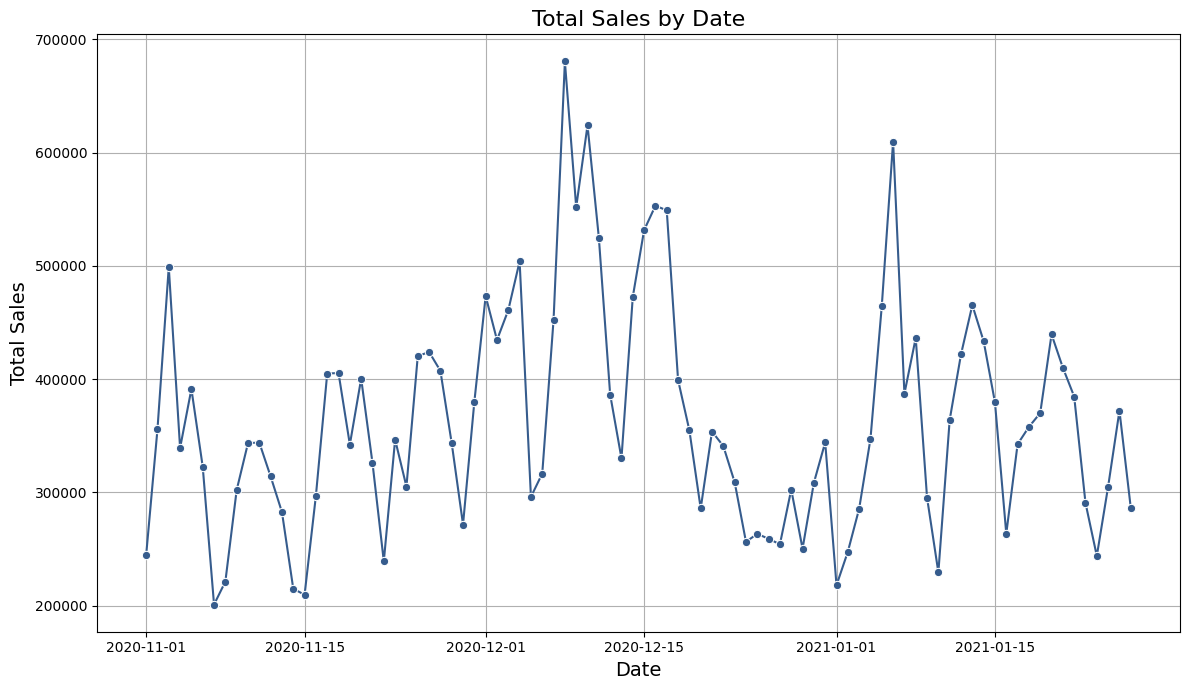

In [ ]:
# Grouping data by date and summing sales
daily_sales = df.groupby('order_date')['price'].sum().reset_index()

# Visualization of overall sales dynamics by date
plt.figure(figsize=(12, 7))
sns.lineplot(x='order_date', y='price', data=daily_sales, marker='o', color=sns.color_palette("viridis")[1])

plt.title('Total Sales by Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusions:** The chart shows fluctuations in total sales over time, with a significant peak in early December, indicating a seasonal pattern. This suggests that sales are not consistent throughout the year but are influenced by recurring factors, such as seasonal demand. Therefore, seasonality is evident in the sales data.

## ***2. Analyze The Sales Trend in America, Asia, and Europe***

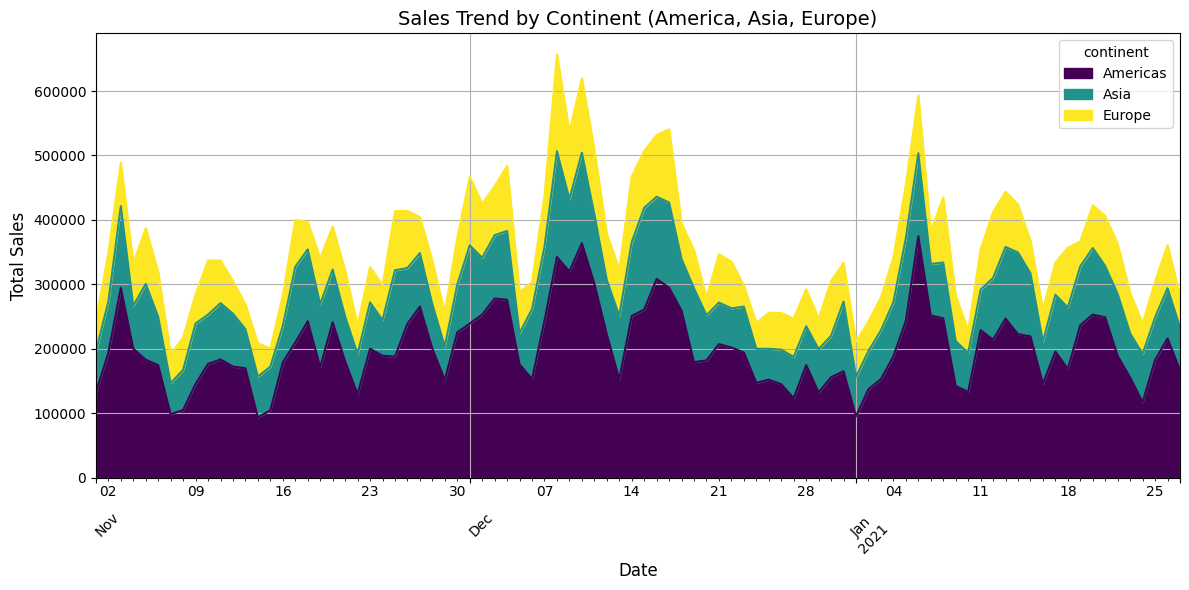

In [ ]:
# Filter the data to only include America, Asia, and Europe
df_filtered = df[df['continent'].isin(['Americas', 'Asia', 'Europe'])]

# Group the data by continent and date, summing up the sales (price) for each combination
df_continent_sales = df_filtered.groupby(['continent', 'order_date'])['price'].sum().reset_index()

# Pivot the data to make continents as columns
df_pivoted = df_continent_sales.pivot(index='order_date', columns='continent', values='price').fillna(0)

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked area chart
df_pivoted.plot(kind='area', stacked=True, colormap='viridis', ax=ax)

# Add title and labels
ax.set_title('Sales Trend by Continent (America, Asia, Europe)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions:** Asia shows the most significant sales growth and volatility, particularly with a large peak in early December. The Americas show a fluctuating trend, but with an overall upward trajectory, and also exhibit a noticeable peak in December. Europe displays more moderate and stable sales, with a less pronounced December increase compared to Asia.

## ***3. Analyze Sales Trend by Traffic Channels***

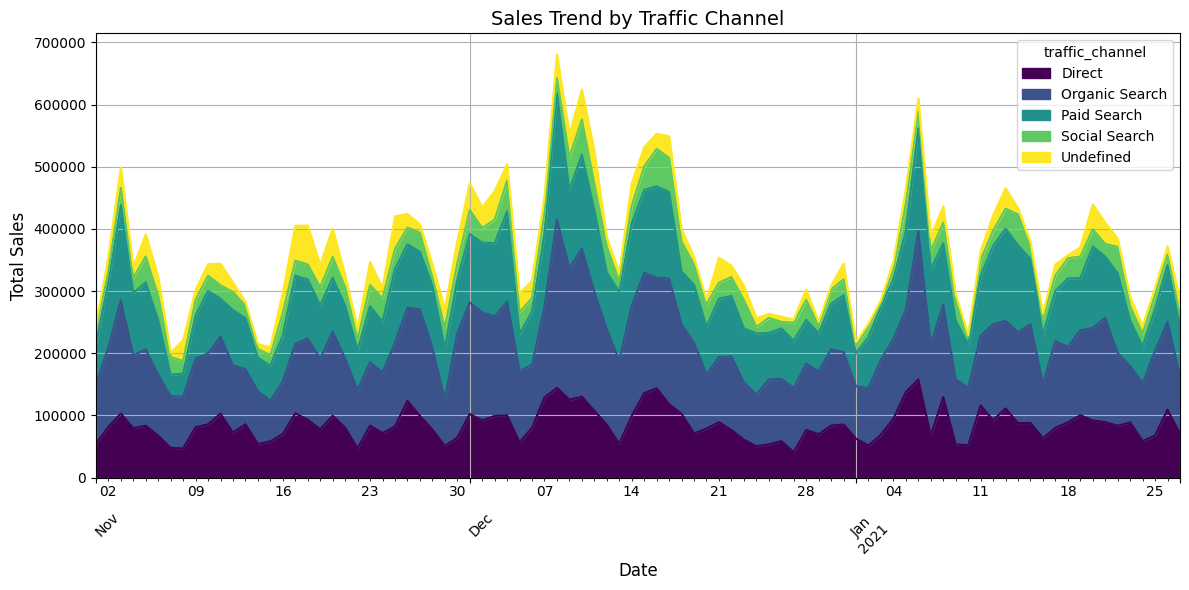

In [ ]:
# Group the data by traffic channel and date, summing up the sales (price) for each combination
df_traffic_sales = df.groupby(['traffic_channel', 'order_date'])['price'].sum().reset_index()

# Pivot the data to make traffic channels as columns
df_traffic_pivoted = df_traffic_sales.pivot(index='order_date', columns='traffic_channel', values='price').fillna(0)

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked area chart with different colors for each traffic channel
df_traffic_pivoted.plot(kind='area', stacked=True, colormap='viridis', ax=ax)

# Add title and labels
ax.set_title('Sales Trend by Traffic Channel', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions:** Organic search and direct traffic consistently contribute a substantial portion of total sales, with organic search showing significant peaks, particularly in early December. Paid search also demonstrates a noticeable peak in December, though its overall contribution is lower than that of organic search and direct traffic. Social search and undefined traffic channels contribute a smaller, yet still significant, portion of the total sales.

## ***4. Analyze Sales Trend by Device Type***

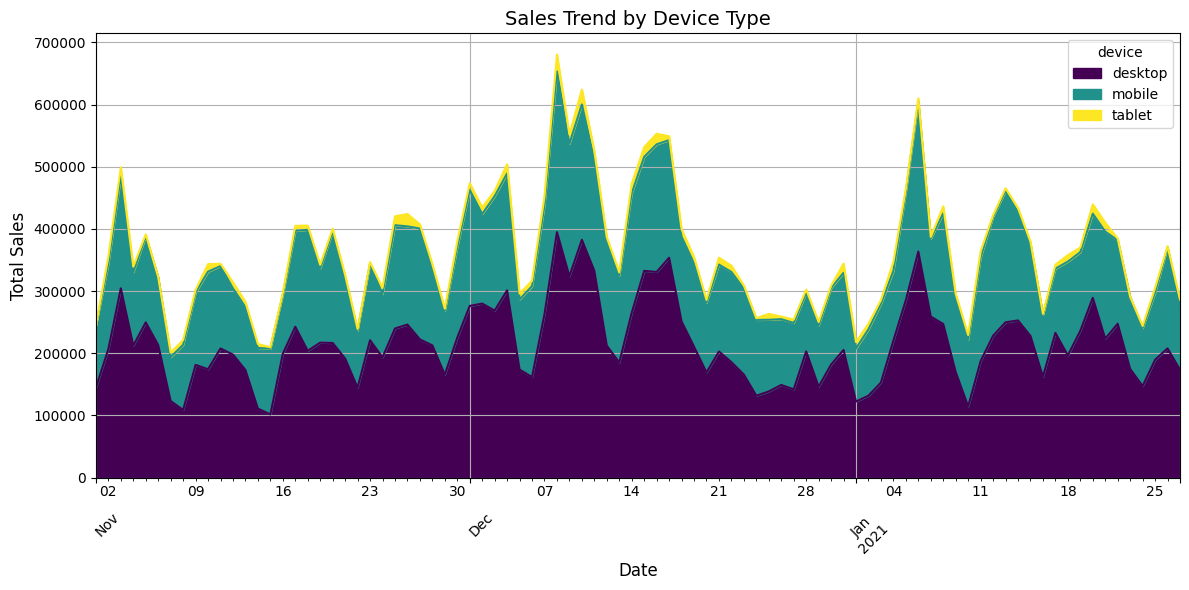

In [ ]:
# Group the data by device type and date, summing up the sales (price) for each combination
df_device_sales = df.groupby(['device', 'order_date'])['price'].sum().reset_index()

# Pivot the data to make device types as columns
df_device_pivoted = df_device_sales.pivot(index='order_date', columns='device', values='price').fillna(0)

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked area chart for device sales
df_device_pivoted.plot(kind='area', stacked=True, colormap='viridis', ax=ax)

# Add title and labels
ax.set_title('Sales Trend by Device Type', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions:** Desktop consistently contributes the largest portion of sales, though mobile shows significant growth and occasional peaks. Tablet sales remain the lowest and most stable throughout the period. All three device types experience a notable surge in sales in early December, indicating a shared seasonal pattern.

**Explanation:** Sales trends and seasonality are explored across various factors. Overall sales fluctuations are visualized, highlighting a peak in December, while continental sales are compared, emphasizing Asia's growth and Europe's stability. Sales by traffic channel are examined, identifying organic and direct traffic as major contributors, and by device type, with desktop leading and all devices showing a surge in December.

# **Pivot Tables**

## ***1. Analyze Sessions by Traffic Channel and Device Type***


In [ ]:
# Ensure there are no missing values in 'traffic_channel' and 'device' columns
df_filtered = df.dropna(subset=['traffic_channel', 'device'])

# Create the pivot table to count sessions by traffic channel and device type
pivot_table = df_filtered.pivot_table(
    index='traffic_channel',
    columns='device',
    values='ga_session_id',
    aggfunc='count',
    fill_value=0
)

# Display the pivot table
print(pivot_table)

device           desktop  mobile  tablet
traffic_channel                         
Direct              4655    2985     160
Organic Search      7011    4655     255
Paid Search         5261    3574     207
Social Search       1594    1065      57
Undefined           1181     834      44


## ***2. Analyze Total Sales by Product Category and Country***

In [ ]:
# 1. Filter out the top 10 product categories based on total sales
top_10_categories = df.groupby('product_category')['price'].sum().sort_values(ascending=False).head(10).index
df_filtered_categories = df[df['product_category'].isin(top_10_categories)]

# 2. Filter out the top 5 countries based on total sales
top_5_countries = df_filtered_categories.groupby('country')['price'].sum().sort_values(ascending=False).head(5).index
df_filtered_countries = df_filtered_categories[df_filtered_categories['country'].isin(top_5_countries)]

# 3. Create the pivot table showing total sales by product category (rows) and country (columns)
pivot_table_sales = df_filtered_countries.pivot_table(
    index='product_category',
    columns='country',
    values='price',
    aggfunc='sum',
    fill_value=0
)

# 4. Display the resulting pivot table
print(pivot_table_sales)

country                             Canada    France     India  \
product_category                                                 
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
product_category                                                 
Bar furniture                            22103.0       330805.0  
Beds     

## ***3. Analyze Total Sales by Traffic Channel and Device Type***

In [ ]:
# Create the pivot table showing total sales (price) by traffic channel (rows) and device type (columns)
pivot_table_traffic_device = df.pivot_table(
    index='traffic_channel',
    columns='device',
    values='price',
    aggfunc='sum',
    fill_value=0
)

# Display the resulting pivot table
print(pivot_table_traffic_device)

device             desktop     mobile    tablet
traffic_channel                                
Direct           4472609.4  2875317.9  146996.1
Organic Search   6794107.8  4408875.1  230168.7
Paid Search      4976977.8  3330032.6  204039.0
Social Search    1447384.8  1006707.3   78013.6
Undefined        1172959.2   763292.9   64248.9


## ***4. Analyze Sessions by Traffic Source and Country***

In [ ]:
# Create the pivot table showing session count by traffic source (rows) and country (columns)
pivot_table_sessions_traffic_source = df.pivot_table(
    index='traffic_source',
    columns='country',
    values='ga_session_id',
    aggfunc='count',
    fill_value=0
)

# Display the resulting pivot table
print(pivot_table_sessions_traffic_source)

country         (not set)  Albania  Algeria  Argentina  Armenia  Australia  \
traffic_source                                                               
(data deleted)         18        1        1          4        0         25   
(none)                 69        1        5         24        3         64   
<Other>                37        1        1         12        2         49   
cpc                    14        1        0          2        0         14   
organic               102        4        8         25        1        104   
referral               50        2        3         18        3         64   

country         Austria  Azerbaijan  Bahamas  Bahrain  ...  Trinidad & Tobago  \
traffic_source                                         ...                      
(data deleted)        9           0        0        3  ...                  0   
(none)               21           6        0        1  ...                  3   
<Other>              10           2        1       

**Explanation:** Pivot tables are used to analyze sales and user engagement data. Sessions are counted across traffic channels and device types, revealing user interaction patterns. Total sales are aggregated by top product categories and countries, highlighting regional and product-specific sales variations. Revenue contributions are examined by traffic channel and device type, and session counts are tracked by traffic source and country, offering a comprehensive view of how sales and user engagement intersect across various dimensions.

# **Statistical Analysis of Correlations**

## ***1. Analyze Correlation Between Sessions and Sales***

In [ ]:
# 1. Aggregate Data: Sessions & Total Sales per Date

# Group by order_date to calculate session count and total sales
df_summary = df.groupby('order_date').agg(
    session_count=('ga_session_id', 'nunique'),  # Count unique sessions
    total_sales=('price', 'sum')  # Sum of sales per date
).reset_index()

# Display first few rows
print(df_summary.head())

  order_date  session_count  total_sales
0 2020-11-01            281     244292.5
1 2020-11-02            368     355506.8
2 2020-11-03            561     498979.6
3 2020-11-04            370     339187.1
4 2020-11-05            388     391276.6


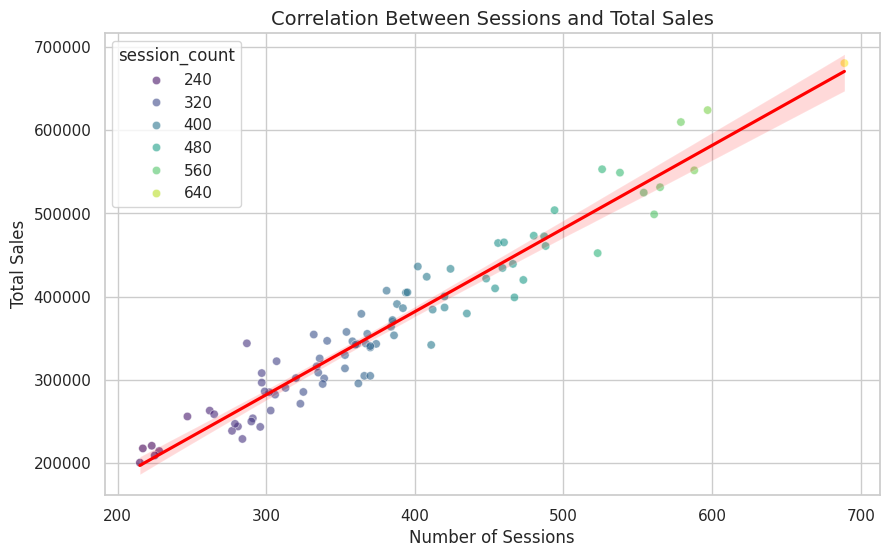

In [ ]:
# 2. Visualize the Relationship Between Sessions & Sales

# Set seaborn style
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(10, 6))

# First, plot the scatter plot using 'viridis' colormap
sns.scatterplot(x=df_summary['session_count'],
                y=df_summary['total_sales'],
                hue=df_summary['session_count'],  # Color by session_count
                palette='viridis',
                alpha=0.6)

# Then, add the regression line
sns.regplot(x=df_summary['session_count'],
            y=df_summary['total_sales'],
            scatter=False,  # Don't plot scatter points again
            line_kws={'color': 'red'})  # Set the regression line color

# Add labels and title
plt.xlabel("Number of Sessions", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.title("Correlation Between Sessions and Total Sales", fontsize=14)

# Show the plot
plt.show()

In [ ]:
# 3. Compute Pearson Correlation

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(df_summary['session_count'], df_summary['total_sales'])

print(f"Pearson Correlation Coefficient: {correlation:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson Correlation Coefficient: 0.9642
P-Value: 0.0000
The correlation is statistically significant.


**Conclusions:** There is a strong positive linear correlation between the number of sessions and total sales, as shown by the tight clustering of data points around the regression line. A Pearson correlation coefficient of 0.9642 and a p-value of 0.0000 confirm this robust relationship, indicating that an increase in sessions is highly associated with an increase in sales. This correlation is statistically significant, meaning it is unlikely to be due to random chance.

## ***2. Analyze Correlation Between Sales Across Continents***

In [ ]:
# 1. Aggregate Data: Sales by Continent per Date

# Filter the data for the top 3 continents
top_3_continents = df['continent'].value_counts().head(3).index
df_top_3_continents = df[df['continent'].isin(top_3_continents)]

# Group by continent and order_date to get total sales per continent
df_sales_by_continent = df_top_3_continents.groupby(['continent', 'order_date'])['price'].sum().reset_index()

# Pivot the data so that each continent is a separate column
df_pivoted_sales = df_sales_by_continent.pivot(index='order_date', columns='continent', values='price').fillna(0)

# Display the first few rows
print(df_pivoted_sales.head())

continent   Americas      Asia   Europe
order_date                             
2020-11-01  132002.5   63823.0  46908.0
2020-11-02  193861.0   79370.0  75710.8
2020-11-03  294529.8  126737.8  67692.0
2020-11-04  200009.5   66602.0  65915.0
2020-11-05  182988.2  117608.4  86540.0


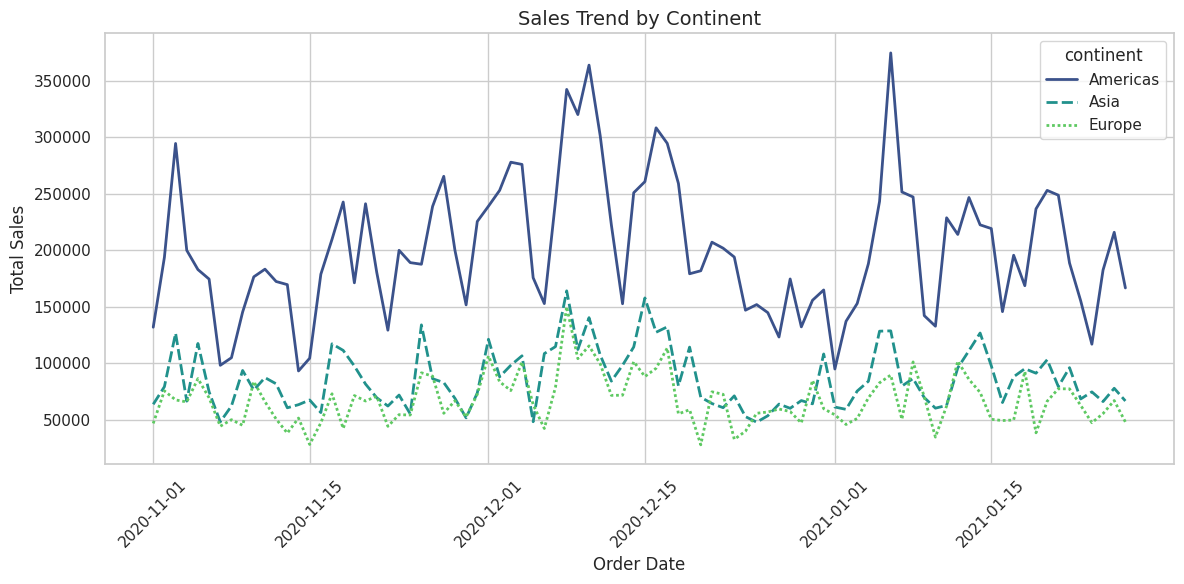

In [ ]:
# 2. Visualize the Relationship Between Sales Across Continents

# Set seaborn style
sns.set(style="whitegrid")

# Create a line plot for the sales trend by continent
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pivoted_sales, palette='viridis', linewidth=2)

# Add labels and title
plt.title('Sales Trend by Continent', fontsize=14)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# 3. Compute Pearson Correlation

# Calculate and interpret the correlation between sales of different continents
for continent1 in top_3_continents:
    for continent2 in top_3_continents:
        if continent1 != continent2:
            sales1 = df_pivoted_sales[continent1]
            sales2 = df_pivoted_sales[continent2]

            # Calculate Pearson correlation and p-value
            correlation, p_value = pearsonr(sales1, sales2)

            print(f"Correlation between {continent1} and {continent2}: {correlation:.4f}")
            print(f"P-value: {p_value:.4f}")

            # Interpretation of p-value
            if p_value < 0.05:
                print(f"The correlation between {continent1} and {continent2} is statistically significant.\n")
            else:
                print(f"The correlation between {continent1} and {continent2} is not statistically significant.\n")

Correlation between Americas and Asia: 0.6923
P-value: 0.0000
The correlation between Americas and Asia is statistically significant.

Correlation between Americas and Europe: 0.6695
P-value: 0.0000
The correlation between Americas and Europe is statistically significant.

Correlation between Asia and Americas: 0.6923
P-value: 0.0000
The correlation between Asia and Americas is statistically significant.

Correlation between Asia and Europe: 0.6678
P-value: 0.0000
The correlation between Asia and Europe is statistically significant.

Correlation between Europe and Americas: 0.6695
P-value: 0.0000
The correlation between Europe and Americas is statistically significant.

Correlation between Europe and Asia: 0.6678
P-value: 0.0000
The correlation between Europe and Asia is statistically significant.



**Conclusions:** The sales trends across the continents exhibit a statistically significant positive correlation. The correlation coefficients, ranging from 0.6678 to 0.6923, suggest a moderate to strong positive relationship between sales in the Americas, Asia, and Europe. This indicates that fluctuations in sales on one continent tend to be mirrored in others, likely driven by shared global economic factors or seasonal patterns.

## ***3.  Analyze Correlation Between Sales Across Traffic Channels***

In [ ]:
# 1. Aggregate Data: Sales by Traffic Channel per Date

# Filter the data for the relevant traffic channels (assuming 'traffic_channel' column exists)
df_traffic_channels = df[['traffic_channel', 'order_date', 'price']]

# Group by traffic channel and order_date to get total sales per channel
df_sales_by_channel = df_traffic_channels.groupby(['traffic_channel', 'order_date'])['price'].sum().reset_index()

# Pivot the data so that each traffic channel is a separate column
df_pivoted_sales_channel = df_sales_by_channel.pivot(index='order_date', columns='traffic_channel', values='price').fillna(0)

# Display the first few rows
print(df_pivoted_sales_channel.head())

traffic_channel    Direct  Organic Search  Paid Search  Social Search  \
order_date                                                              
2020-11-01        54669.5         95112.0      64688.0        25078.0   
2020-11-02        81561.5        127746.5     104780.8        16843.0   
2020-11-03       102909.5        182521.9     152641.3        27652.5   
2020-11-04        79683.6        117067.1     100332.0        24257.4   
2020-11-05        83367.6        122938.4     107648.0        41693.2   

traffic_channel  Undefined  
order_date                  
2020-11-01          4745.0  
2020-11-02         24575.0  
2020-11-03         33254.4  
2020-11-04         17847.0  
2020-11-05         35629.4  


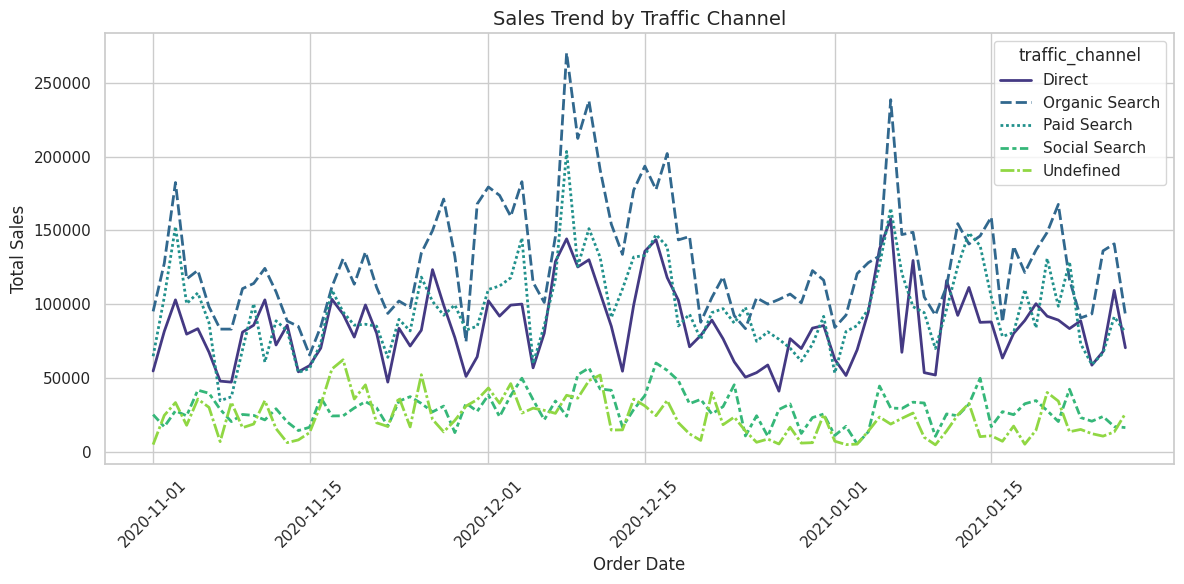

In [ ]:
# 2. Visualize the Relationship Between Sales Across Traffic Channels

# Set seaborn style
sns.set(style="whitegrid")

# Create a line plot for the sales trend by traffic channel
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pivoted_sales_channel, palette='viridis', linewidth=2)

# Add labels and title
plt.title('Sales Trend by Traffic Channel', fontsize=14)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# 3. Compute Pearson Correlation

# Calculate and interpret the correlation between sales of different traffic channels
traffic_channels = df_pivoted_sales_channel.columns

for channel1 in traffic_channels:
    for channel2 in traffic_channels:
        if channel1 != channel2:
            sales1 = df_pivoted_sales_channel[channel1]
            sales2 = df_pivoted_sales_channel[channel2]

            # Calculate Pearson correlation and p-value
            correlation, p_value = pearsonr(sales1, sales2)

            print(f"Correlation between {channel1} and {channel2}: {correlation:.4f}")
            print(f"P-value: {p_value:.4f}")

            # Interpretation of p-value
            if p_value < 0.05:
                print(f"The correlation between {channel1} and {channel2} is statistically significant.\n")
            else:
                print(f"The correlation between {channel1} and {channel2} is not statistically significant.\n")

Correlation between Direct and Organic Search: 0.7599
P-value: 0.0000
The correlation between Direct and Organic Search is statistically significant.

Correlation between Direct and Paid Search: 0.7243
P-value: 0.0000
The correlation between Direct and Paid Search is statistically significant.

Correlation between Direct and Social Search: 0.4619
P-value: 0.0000
The correlation between Direct and Social Search is statistically significant.

Correlation between Direct and Undefined: 0.4240
P-value: 0.0000
The correlation between Direct and Undefined is statistically significant.

Correlation between Organic Search and Direct: 0.7599
P-value: 0.0000
The correlation between Organic Search and Direct is statistically significant.

Correlation between Organic Search and Paid Search: 0.8082
P-value: 0.0000
The correlation between Organic Search and Paid Search is statistically significant.

Correlation between Organic Search and Social Search: 0.4344
P-value: 0.0000
The correlation between O

**Conclusions:** The sales trends across different traffic channels exhibit statistically significant correlations, although the strength of these relationships varies. Direct, organic, and paid search channels show strong positive correlations (0.72 - 0.81), indicating that their sales patterns are likely influenced by similar factors. Social and undefined channels show weaker, yet still significant, positive correlations with the other channels (0.35 - 0.46), suggesting that they are influenced by some of the same factors, but may also have unique drivers. The consistently low p-values (all below 0.0006) confirm the statistical significance of these correlations, indicating that they are highly unlikely to be due to random chance.

## ***4. Analyze Correlation Of Sales Across The Top 5 Product Categories***

In [ ]:
# 1. Aggregate Data:
# Identify the top-5 product categories by sales
top_5_categories = df.groupby('product_category')['price'].sum().nlargest(5).index
df_top_5_categories = df[df['product_category'].isin(top_5_categories)]

# Group by category and order_date to get total sales per category
df_sales_by_category = df_top_5_categories.groupby(['product_category', 'order_date'])['price'].sum().reset_index()

# Pivot the data so that each category is a separate column
df_pivoted_sales_category = df_sales_by_category.pivot(index='order_date', columns='product_category', values='price').fillna(0)

# Compute Pearson Correlation Matrix
correlation_matrix = df_pivoted_sales_category.corr(method='pearson')

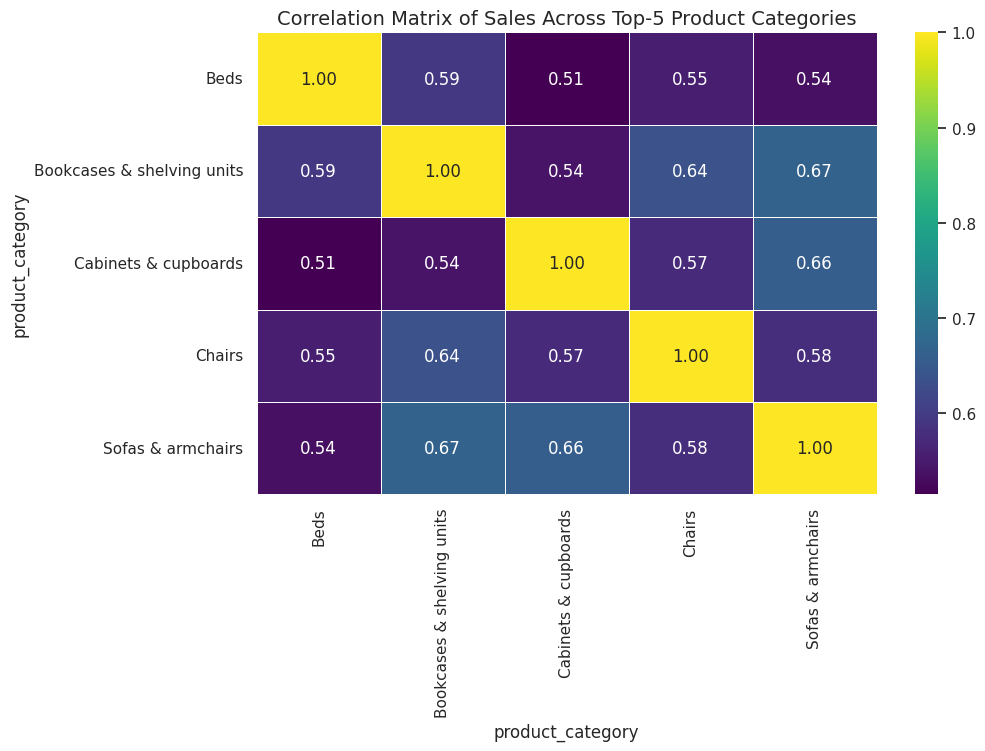

In [ ]:
# 2. Visualize the Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Sales Across Top-5 Product Categories', fontsize=14)
plt.show()

In [ ]:
# 3. Compute Pearson Correlation

# Calculate and interpret the correlation between sales of different product categories
for category1 in top_5_categories:
    for category2 in top_5_categories:
        if category1 != category2:
            sales1 = df_pivoted_sales_category[category1]
            sales2 = df_pivoted_sales_category[category2]

            # Calculate Pearson correlation and p-value
            correlation, p_value = pearsonr(sales1, sales2)

            print(f"Correlation between {category1} and {category2}: {correlation:.4f}")
            print(f"P-value: {p_value:.4f}")

            # Interpretation of p-value
            if p_value < 0.05:
                print(f"The correlation between {category1} and {category2} is statistically significant.\n")
            else:
                print(f"The correlation between {category1} and {category2} is not statistically significant.\n")

Correlation between Sofas & armchairs and Chairs: 0.5782
P-value: 0.0000
The correlation between Sofas & armchairs and Chairs is statistically significant.

Correlation between Sofas & armchairs and Beds: 0.5354
P-value: 0.0000
The correlation between Sofas & armchairs and Beds is statistically significant.

Correlation between Sofas & armchairs and Bookcases & shelving units: 0.6662
P-value: 0.0000
The correlation between Sofas & armchairs and Bookcases & shelving units is statistically significant.

Correlation between Sofas & armchairs and Cabinets & cupboards: 0.6576
P-value: 0.0000
The correlation between Sofas & armchairs and Cabinets & cupboards is statistically significant.

Correlation between Chairs and Sofas & armchairs: 0.5782
P-value: 0.0000
The correlation between Chairs and Sofas & armchairs is statistically significant.

Correlation between Chairs and Beds: 0.5545
P-value: 0.0000
The correlation between Chairs and Beds is statistically significant.

Correlation between 

**Conclusions:** The sales trends across the top five product categories show statistically significant positive correlations, with coefficients ranging from 0.51 to 0.67, indicating moderate relationships. These trends suggest shared influences, such as seasonal patterns or marketing efforts, as fluctuations in one category often mirror others. The consistently low p-values (all 0.0000) confirm that these correlations are unlikely to be due to random chance.

## ***5. Analyze Correlation Between Sales And Device Type***

In [ ]:
# 1. Aggregate Data: Sales by Device per Date

# Group by order_date and device, calculating total sales per device
df_sales_by_device = df.groupby(['order_date', 'device'])['price'].sum().reset_index()

# Pivot the data so that each device is a separate column
df_pivoted_sales_device = df_sales_by_device.pivot(index='order_date', columns='device', values='price').fillna(0)

# Display the first few rows
print(df_pivoted_sales_device.head())

device       desktop    mobile   tablet
order_date                             
2020-11-01  144445.0   99698.5    149.0
2020-11-02  206727.3  137269.5  11510.0
2020-11-03  304473.8  180602.8  13903.0
2020-11-04  212227.7  118324.4   8635.0
2020-11-05  249682.0  138256.0   3338.6


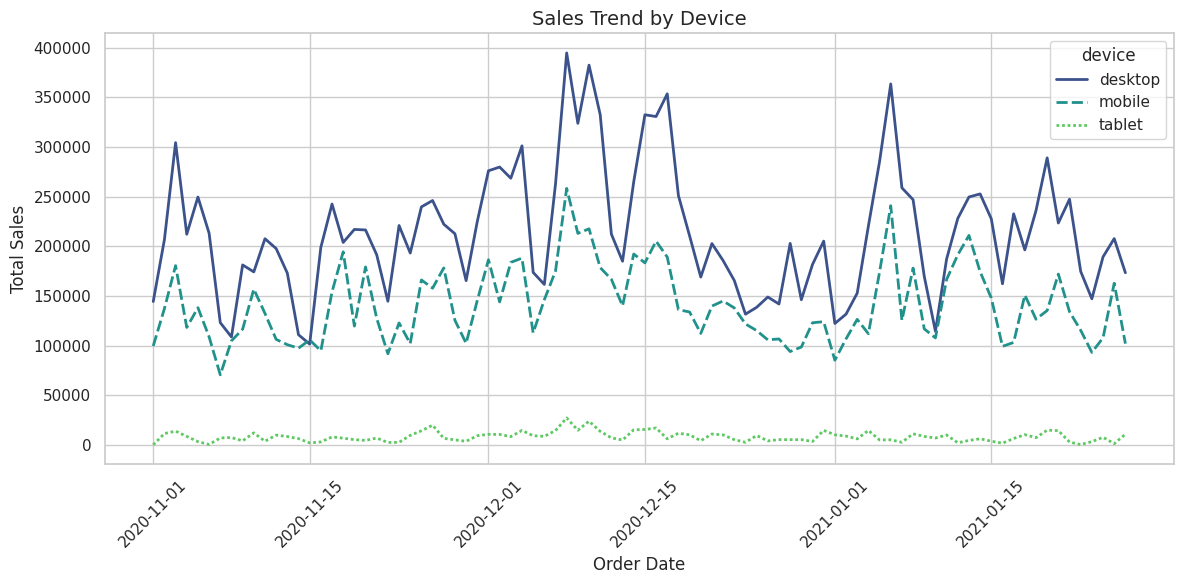

In [ ]:
# 2. Visualize the Relationship Between Sales Across Devices

# Set seaborn style
sns.set(style="whitegrid")

# Create a line plot for sales trends by device
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pivoted_sales_device, palette='viridis', linewidth=2)

# Add labels and title
plt.title('Sales Trend by Device', fontsize=14)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# 3. Compute Pearson Correlation Between Sales and Devices
for device in df['device'].unique():
    # Select sales data corresponding to the device
    sales_device = df_pivoted_sales_device[device]

    # Ensure we are comparing with the total sales column (not individual device price)
    total_sales = df_pivoted_sales_device.sum(axis=1)  # Sum of all devices' sales for each date

    # Calculate Pearson correlation between sales for each device and total sales
    correlation, p_value = pearsonr(sales_device, total_sales)

    print(f"Correlation between sales and device {device}: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpretation of p-value
    if p_value < 0.05:
        print(f"The correlation is statistically significant.\n")
    else:
        print(f"The correlation is not statistically significant.\n")

        print(f"The correlation is not statistically significant.\n")

Correlation between sales and device desktop: 0.9718
P-value: 0.0000
The correlation is statistically significant.

Correlation between sales and device mobile: 0.9203
P-value: 0.0000
The correlation is statistically significant.

Correlation between sales and device tablet: 0.5831
P-value: 0.0000
The correlation is statistically significant.



**Conclusions:** All three devices (desktop, mobile, tablet) show statistically significant positive correlations with sales, with desktop and mobile devices exhibiting stronger correlations compared to tablets. The p-values of 0.0000 indicate that these correlations are highly unlikely to be due to random chance, and they suggest that sales trends are influenced by traffic from these devices.

**Explanation:** Relationships within sales data are investigated using correlation techniques. A strong positive correlation is identified between daily session counts and sales, suggesting that more sessions lead to higher sales. Sales across continents, traffic channels, and product categories are then examined, revealing significant positive correlations in each, indicating common factors influencing sales trends. Finally, the correlation between sales and device types is explored, showing a significant positive relationship across all devices, with desktop and mobile having the strongest influence on overall sales.

# **Statistical Analysis of Differences Between Groups**

## ***1. Sales Comparison: Registered vs Unregistered Users***

In [ ]:
# Create separate datasets for registered and unregistered users
df_registered = df[df['email_confirmed'] == 1]
df_unregistered = df[df['email_confirmed'] == 0]

# Group by order_date and calculate total sales for both registered and unregistered users
sales_registered = df_registered.groupby('order_date')['price'].sum()
sales_unregistered = df_unregistered.groupby('order_date')['price'].sum()

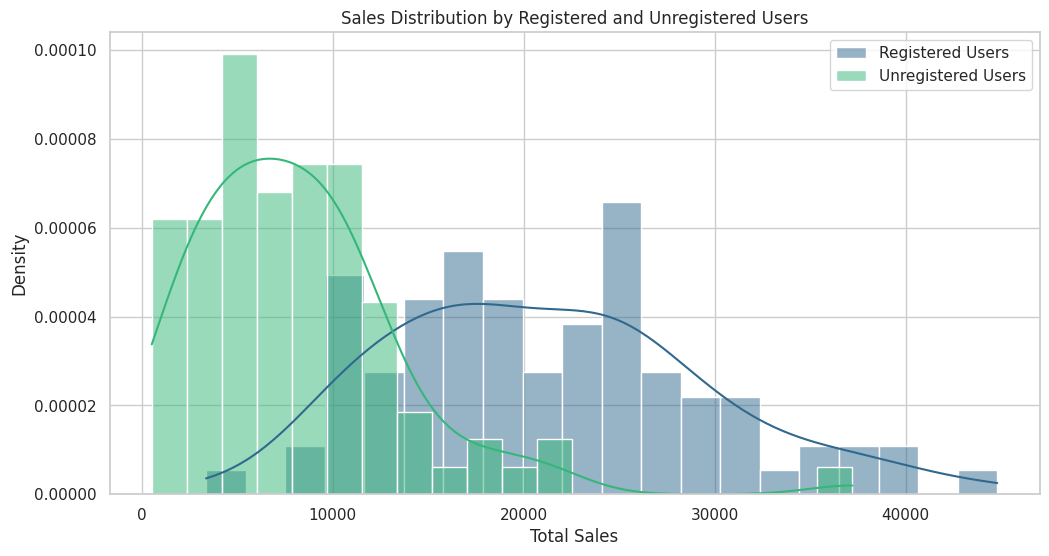

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# Define colors using the 'viridis' colormap
colors = sns.color_palette('viridis', 2)  # Two colors for the registered and unregistered users

# Plot distributions for both groups
plt.figure(figsize=(12, 6))

# Plot for registered users with the first color from the 'viridis' palette
sns.histplot(sales_registered, kde=True, color=colors[0], label='Registered Users', stat='density', bins=20)

# Plot for unregistered users with the second color from the 'viridis' palette
sns.histplot(sales_unregistered, kde=True, color=colors[1], label='Unregistered Users', stat='density', bins=20)

# Title and labels
plt.title('Sales Distribution by Registered and Unregistered Users')
plt.xlabel('Total Sales')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Perform statistical test (Mann-Whitney U test for non-parametric data or t-test for parametric data)
# Check normality of the sales data for both groups using Shapiro-Wilk test
stat_registered, p_registered = stats.shapiro(sales_registered)
stat_unregistered, p_unregistered = stats.shapiro(sales_unregistered)

print(f"Shapiro-Wilk test for registered users p-value: {p_registered}")
print(f"Shapiro-Wilk test for unregistered users p-value: {p_unregistered}")

# If both are normal, use t-test; if not, use Mann-Whitney U test
if p_registered > 0.05 and p_unregistered > 0.05:
    print("Both groups are normally distributed. Using t-test for comparison.")
    t_stat, p_val = stats.ttest_ind(sales_registered, sales_unregistered)
else:
    print("One or both groups are not normally distributed. Using Mann-Whitney U test for comparison.")
    t_stat, p_val = stats.mannwhitneyu(sales_registered, sales_unregistered)

print(f"Test Statistic: {t_stat}")
print(f"P-value: {p_val}")

# Interpretation of p-value
if p_val < 0.05:
    print("The difference between sales of registered and unregistered users is statistically significant.")
else:
    print("The difference between sales of registered and unregistered users is not statistically significant.")

Shapiro-Wilk test for registered users p-value: 0.11325964679068223
Shapiro-Wilk test for unregistered users p-value: 1.660135980785686e-07
One or both groups are not normally distributed. Using Mann-Whitney U test for comparison.
Test Statistic: 7147.0
P-value: 3.3672889331306305e-22
The difference between sales of registered and unregistered users is statistically significant.


**Conclusions:** The analysis of sales distributions for registered users showed that their distribution is approximately normal (p-value: 0.113), while for unregistered users, the distribution is not normal (p-value: 1.66e-07). Since one of the samples does not meet the normality assumption, the *Mann-Whitney U test* was used for comparison. The results of the test (p-value: 3.37e-22) indicate that the difference in sales between registered and unregistered users is statistically significant, suggesting that the registration status plays a significant role in sales volume.

## ***2. Analysis of Sessions by Traffic Channels***

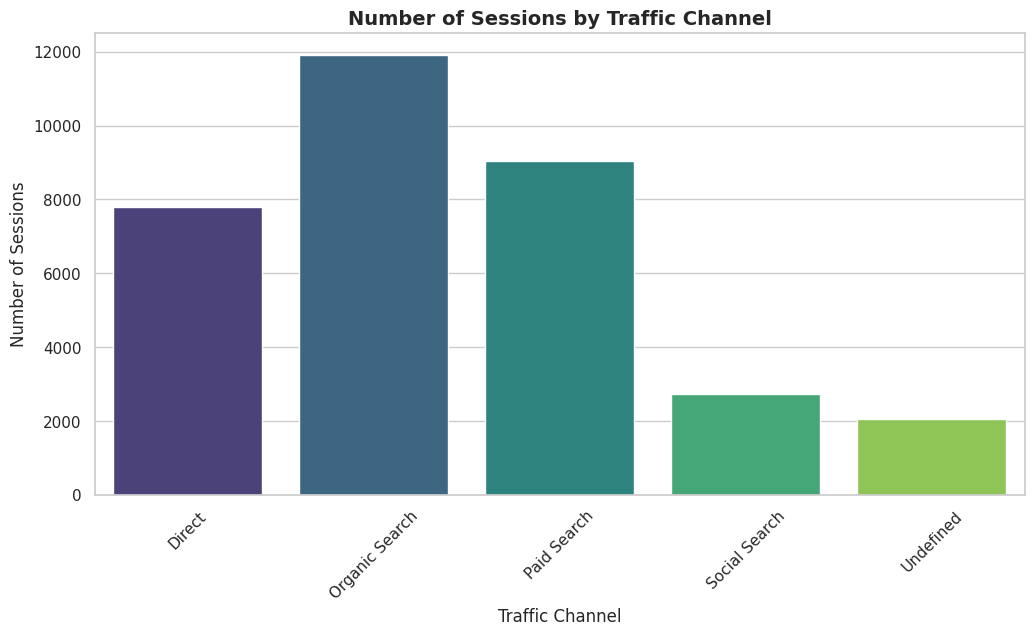

In [ ]:
# Group the data by traffic channels and calculate the number of sessions per channel
sessions_by_channel = df.groupby('traffic_channel')['ga_session_id'].nunique()

# Set seaborn style
sns.set(style="whitegrid")

# Group the data by traffic channels and calculate the number of sessions per channel
sessions_by_channel = df.groupby('traffic_channel')['ga_session_id'].nunique()

# Define colors using the 'viridis' colormap
colors = sns.color_palette('viridis', len(sessions_by_channel))  # Define colors for each traffic channel

# Create the figure
plt.figure(figsize=(12, 6))

# Plot the number of sessions for each traffic channel using a barplot
sns.barplot(x=sessions_by_channel.index, y=sessions_by_channel.values, hue=sessions_by_channel.index, palette=colors, legend=False)

# Title and labels
plt.title('Number of Sessions by Traffic Channel', fontsize=14, fontweight='bold')
plt.xlabel('Traffic Channel', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Group the data by traffic channels and gather the session IDs for each channel
sessions_by_channel = df.groupby('traffic_channel')['ga_session_id'].apply(list)

# Perform Shapiro-Wilk test for normality only on traffic channels with at least 3 sessions
shapiro_p_values = {}
for channel, sessions in sessions_by_channel.items():
    if len(sessions) >= 3:  # Ensure that there are at least 3 sessions
        p_value = stats.shapiro(sessions)[1]
        shapiro_p_values[channel] = p_value

print(f"Shapiro-Wilk p-values for normality:\n{shapiro_p_values}")

# If any channel doesn't follow normal distribution, use the Kruskal-Wallis test
if any(p_value < 0.05 for p_value in shapiro_p_values.values()):
    # Kruskal-Wallis test for comparing groups with non-normal distributions
    h_stat, p_value = stats.kruskal(*sessions_by_channel)
    print(f"Kruskal-Wallis Test Statistic: {h_stat}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("There are statistically significant differences between the traffic channels.")
    else:
        print("There are no statistically significant differences between the traffic channels.")
else:
    print("Data is normally distributed for all channels. Consider using ANOVA.")

Shapiro-Wilk p-values for normality:
{'Direct': np.float64(1.3541736148917877e-43), 'Organic Search': np.float64(3.4253025936285137e-50), 'Paid Search': np.float64(7.192519406854411e-47), 'Social Search': np.float64(1.6858780219796995e-27), 'Undefined': np.float64(1.6684515639791673e-25)}
Kruskal-Wallis Test Statistic: 6.964735726534855
P-value: 0.13776355738680546
There are no statistically significant differences between the traffic channels.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7800.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11921.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9042.



**Conclusions:** *The Shapiro-Wilk* test results indicate that all traffic channels (Direct, Organic Search, Paid Search, Social Search, and Undefined) do not follow a normal distribution, as all p-values are very close to zero (much smaller than 0.05). Since the data is not normally distributed, is used the Kruskal-Wallis test for comparing the session counts across different traffic channels. *The Kruskal-Wallis* test statistic is 6.96, and the p-value is 0.138, which is greater than the 0.05 significance level. This suggests that there are no statistically significant differences between the session counts of different traffic channels.

## ***3. Comparing the Proportion of Organic Traffic Sessions Between Europe and America***

In [ ]:
# Filter data for Europe and America
df_europe = df[df['continent'] == 'Europe']
df_america = df[df['continent'] == 'America']

# Count sessions for Organic Search and other traffic sources in both regions
organic_europe = df_europe[df_europe['traffic_channel'] == 'Organic Search'].shape[0]
total_europe = df_europe.shape[0]
organic_america = df_america[df_america['traffic_channel'] == 'Organic Search'].shape[0]
total_america = df_america.shape[0]

# Create a contingency table
contingency_table = [[organic_europe, total_europe - organic_europe],
                     [organic_america, total_america - organic_america]]

# Choose the appropriate test
if min(contingency_table[0] + contingency_table[1]) >= 5:
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    test_name = "Chi-square test"
else:
    _, p_value = fisher_exact(contingency_table)
    test_name = "Fisher’s exact test"

# Print results
print(f"Test used: {test_name}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The proportion of organic traffic sessions differs significantly between Europe and America.")
else:
    print("There is no statistically significant difference in the proportion of organic traffic sessions between Europe and America.")

Test used: Fisher’s exact test
P-value: 1.0
There is no statistically significant difference in the proportion of organic traffic sessions between Europe and America.


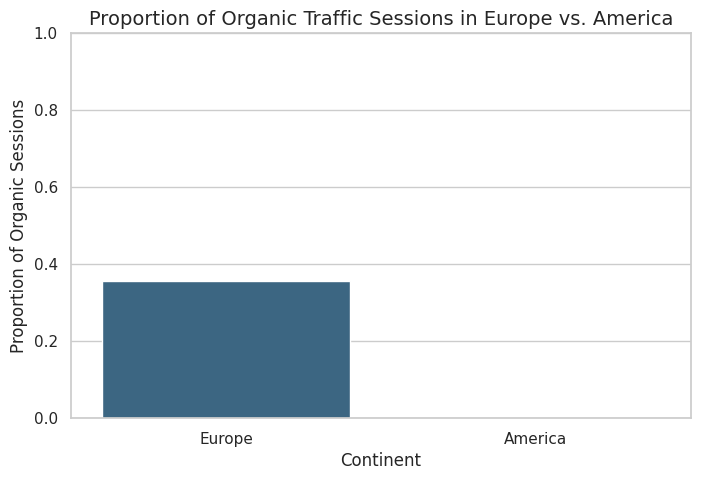

In [ ]:
# Set style
sns.set(style="whitegrid")

# Define color palette (same as previous)
colors = sns.color_palette('viridis', 2)

# Avoid ZeroDivisionError
europe_ratio = organic_europe / total_europe if total_europe > 0 else 0
america_ratio = organic_america / total_america if total_america > 0 else 0

# Create a DataFrame for visualization
data = pd.DataFrame({
    "Continent": ["Europe", "America"],
    "Proportion": [europe_ratio, america_ratio]
})

# Create figure
plt.figure(figsize=(8, 5))

# Create barplot with explicit hue
sns.barplot(
    data=data,
    x="Continent",
    y="Proportion",
    hue="Continent",  # Assign hue to avoid the warning
    palette=colors,
    legend=False  # Hide redundant legend
)

# Labels and title
plt.title("Proportion of Organic Traffic Sessions in Europe vs. America", fontsize=14)
plt.ylabel("Proportion of Organic Sessions", fontsize=12)
plt.xlabel("Continent", fontsize=12)
plt.ylim(0, 1)

# Show the plot
plt.show()

**Conclusions:** There is no statistically significant difference in the proportion of organic traffic sessions between Europe and America. A Fisher's exact test was used, resulting in a p-value of 1.0, which indicates no significant difference between the two regions.

**Explanation:** Statistical tests are used to uncover differences between user groups. A significant difference in sales between registered and unregistered users is found, suggesting that registration status impacts purchasing behavior. However, no significant difference is observed in session counts across traffic channels or in the proportion of organic traffic sessions between Europe and America.

## **Stage 2. Analytical Dashboard Creation in Tableau Public**

[E-commerce Analysis Dashboard](https://public.tableau.com/views/E-CommerceAnalysis_17423734364770/Overview?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)